In [39]:
import numpy as np
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize
import matplotlib.pyplot as plt
from glob import glob

working_path = "/disk1/luna16/output/"
image=working_path + "images_0033_0621.npy"
imgs_to_process = np.load(image).astype(np.float64) 
print ("on image", img_file)

on image /disk1/luna16/output/images_0026_1125.npy


(array([5.5772e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

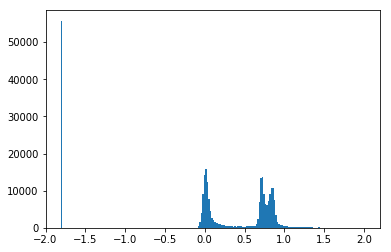

In [40]:
import matplotlib.pyplot as plt
img = imgs_to_process[0]
#Standardize the pixel values
mean = np.mean(img)
std = np.std(img)
img = img-mean
img = img/std
plt.hist(img.flatten(),bins=200)

We have to make sure that we set our threshold between the lung pixel values and the denser tissue pixel values.

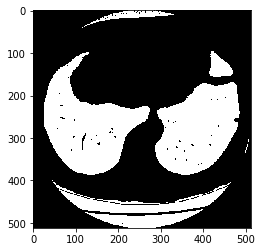

In [57]:
middle = img[100:400,100:400] 
mean = np.mean(middle)  
max = np.max(img)
min = np.min(img)
#move the underflow bins
img[img==max]=mean
img[img==min]=mean

kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
centers = sorted(kmeans.cluster_centers_.flatten())
threshold = np.mean(centers)
thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

plt.imshow(thresh_img,cmap='gray')

# apply erosion and dilation

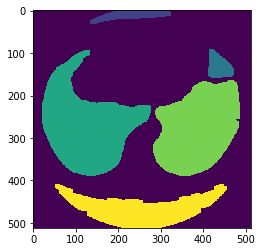

In [42]:
eroded = morphology.erosion(thresh_img,np.ones([4,4]))
dilation = morphology.dilation(eroded,np.ones([10,10]))
labels = measure.label(dilation)
label_vals = np.unique(labels)
plt.imshow(labels)

## lungs are generally far away from the top and bottom of the image, so any regions that are too close to the top and bottom are removed

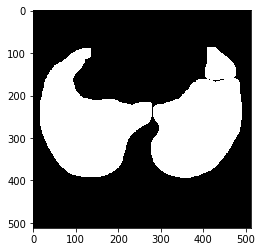

In [43]:
labels = measure.label(dilation)
label_vals = np.unique(labels)
regions = measure.regionprops(labels)
good_labels = []
for prop in regions:
    B = prop.bbox
    if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>40 and B[2]<472:
        good_labels.append(prop.label)
mask = np.ndarray([512,512],dtype=np.int8)
mask[:] = 0
#
#  The mask here is the mask for the lungs--not the nodes
#  After just the lungs are left, we do another large dilation
#  in order to fill in and out the lung mask 
#
for N in good_labels:
    mask = mask + np.where(labels==N,1,0)
mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
plt.imshow(mask,cmap='gray')

# Applying the masks and cropping and resizing the image
applying the mask of the lung ROI to each of the images, cropping down to the bounding square of the lungs ROI, and then resizing the resulting image to 512 X 512.

In [50]:
sample_mask = working_path+"lungmask_0033_0621.npy"
sample_img = working_path+"images_0033_0621.npy"
masks = np.load(sample_mask)
imgs = np.load(sample_img)
imgs = masks*imgs

## renormalizing the masked image (in the mask region)

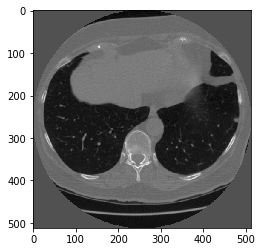

In [45]:
new_mean = np.mean(img[mask>0])  
new_std = np.std(img[mask>0])
#
#  Pushing the background color up to the lower end
#  of the pixel range for the lungs
#
old_min = np.min(img)       # background color
img[img==old_min] = new_mean-1.2*new_std   # resetting backgound color
img = img-new_mean
img = img/new_std
plt.imshow(img,cmap='gray')

## Writing out images and masks as 1 channel to feed into unet

In [46]:
#
#  Writing out images and masks as 1 channel arrays for input into network
#
final_images = np.ndarray([num_images,1,512,512],dtype=np.float32)
final_masks = np.ndarray([num_images,1,512,512],dtype=np.float32)
for i in range(num_images):
    final_images[i,0] = out_images[i]
    final_masks[i,0] = out_nodemasks[i]

rand_i = np.random.choice(range(num_images),size=num_images,replace=False)
test_i = int(0.2*num_images)
np.save(working_path+"trainImages.npy",final_images[rand_i[test_i:]])
np.save(working_path+"trainMasks.npy",final_masks[rand_i[test_i:]])
np.save(working_path+"testImages.npy",final_images[rand_i[:test_i]])
np.save(working_path+"testMasks.npy",final_masks[rand_i[:test_i]])

# check roi isolating

image 0


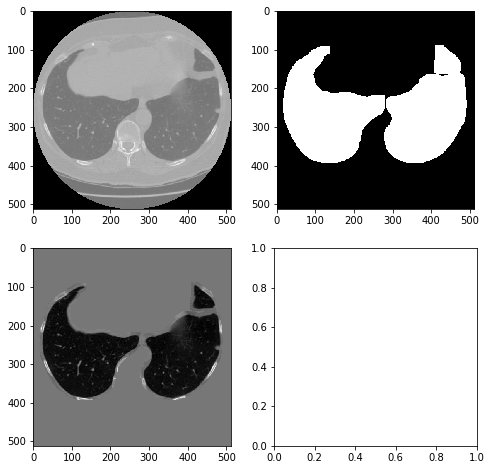

image 1


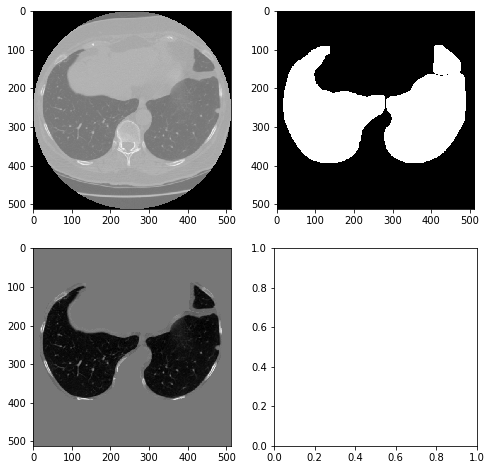

image 2


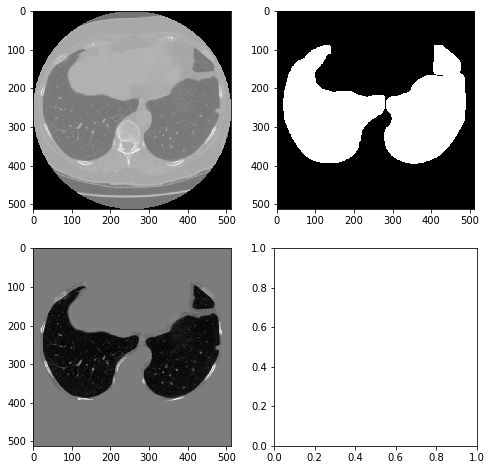

In [52]:
imgs = np.load(sample_img)
lungmask = np.load(sample_mask)

for i in range(len(imgs)):
    print ("image %d" % i)
    fig,ax = plt.subplots(2,2,figsize=[8,8])
    ax[0,0].imshow(imgs[i],cmap='gray')
    ax[0,1].imshow(lungmask[i],cmap='gray')
    ax[1,0].imshow(imgs[i]*lungmask[i],cmap='gray')
    plt.show()

# Run all images

In [ ]:
import numpy as np
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize
import matplotlib.pyplot as plt
from glob import glob

working_path = "/disk1/luna16/output/"
file_list=glob(working_path+"images_*.npy")

for img_file in file_list:
    # I ran into an error when using Kmean on np.float16, so I'm using np.float64 here
    imgs_to_process = np.load(img_file).astype(np.float64) 
    print ("on image", img_file)
    for i in range(len(imgs_to_process)):
        img = imgs_to_process[i]
        #Standardize the pixel values
        mean = np.mean(img)
        std = np.std(img)
        img = img-mean
        img = img/std
        # Find the average pixel value near the lungs
        # to renormalize washed out images
        middle = img[100:400,100:400] 
        mean = np.mean(middle)  
        max = np.max(img)
        min = np.min(img)
        # To improve threshold finding, I'm moving the 
        # underflow and overflow on the pixel spectrum
        img[img==max]=mean
        img[img==min]=mean
        #
        # Using Kmeans to separate foreground (radio-opaque tissue)
        # and background (radio transparent tissue ie lungs)
        # Doing this only on the center of the image to avoid 
        # the non-tissue parts of the image as much as possible
        #
        kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
        centers = sorted(kmeans.cluster_centers_.flatten())
        threshold = np.mean(centers)
        thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image
        #
        # I found an initial erosion helful for removing graininess from some of the regions
        # and then large dialation is used to make the lung region 
        # engulf the vessels and incursions into the lung cavity by 
        # radio opaque tissue
        #
        eroded = morphology.erosion(thresh_img,np.ones([4,4]))
        dilation = morphology.dilation(eroded,np.ones([10,10]))
        #
        #  Label each region and obtain the region properties
        #  The background region is removed by removing regions 
        #  with a bbox that is to large in either dimnsion

        #  This does not produce a perfect segmentation of the lungs
        #  from the image, but it is surprisingly good considering its
        #  simplicity. 
        #
        labels = measure.label(dilation)
        label_vals = np.unique(labels)
        regions = measure.regionprops(labels)
        good_labels = []
        for prop in regions:
            B = prop.bbox
            if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>40 and B[2]<472:
                good_labels.append(prop.label)
        mask = np.ndarray([512,512],dtype=np.int8)
        mask[:] = 0
        #
        #  The mask here is the mask for the lungs--not the nodes
        #  After just the lungs are left, we do another large dilation
        #  in order to fill in and out the lung mask 
        #
        for N in good_labels:
            mask = mask + np.where(labels==N,1,0)
        mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
        imgs_to_process[i] = mask
        print (imgs_to_process)
        
    np.save(img_file.replace("images","lungmask"), imgs_to_process)

In [14]:
file_list=glob(working_path+"lungmask_*.npy")
out_images = []      #final set of images
out_nodemasks = []   #final set of nodemasks
for fname in file_list:
    print ("working on file ", fname)
    imgs_to_process = np.load(fname.replace("lungmask","images"))
    masks = np.load(fname)
    node_masks = np.load(fname.replace("lungmask","masks"))
    for i in range(len(imgs_to_process)):
        mask = masks[i]
        node_mask = node_masks[i]
        img = imgs_to_process[i]
        new_size = [512,512]   # we're scaling back up to the original size of the image
        img= mask*img          # apply lung mask
        #
        # renormalizing the masked image (in the mask region)
        #
        new_mean = np.mean(img[mask>0])  
        new_std = np.std(img[mask>0])
        #
        #  Pulling the background color up to the lower end
        #  of the pixel range for the lungs
        #
        old_min = np.min(img)       # background color
        img[img==old_min] = new_mean-1.2*new_std   # resetting backgound color
        img = img-new_mean
        img = img/new_std
        #make image bounding box  (min row, min col, max row, max col)
        labels = measure.label(mask)
        regions = measure.regionprops(labels)
        #
        # Finding the global min and max row over all regions
        #
        min_row = 512
        max_row = 0
        min_col = 512
        max_col = 0
        for prop in regions:
            B = prop.bbox
            if min_row > B[0]:
                min_row = B[0]
            if min_col > B[1]:
                min_col = B[1]
            if max_row < B[2]:
                max_row = B[2]
            if max_col < B[3]:
                max_col = B[3]
                
        width = max_col-min_col
        height = max_row - min_row
        if width > height:
            max_row=min_row+width
        else:
            max_col = min_col+height
        # 
        # cropping the image down to the bounding box for all regions
        # (there's probably an skimage command that can do this in one line)
        # 
        img = img[min_row:max_row,min_col:max_col]
        mask =  mask[min_row:max_row,min_col:max_col]
        if max_row-min_row <5 or max_col-min_col<5:  # skipping all images with no god regions
            pass
        else:
            # moving range to -1 to 1 to accomodate the resize function
            mean = np.mean(img)
            img = img - mean
            min = np.min(img)
            max = np.max(img)
            img = img/(max-min)
            new_img = resize(img,[512,512])
            new_node_mask = resize(node_mask[min_row:max_row,min_col:max_col],[512,512])
            out_images.append(new_img)
            out_nodemasks.append(new_node_mask)

num_images = len(out_images)
#
#  Writing out images and masks as 1 channel arrays for input into network
#
final_images = np.ndarray([num_images,1,512,512],dtype=np.float32)
final_masks = np.ndarray([num_images,1,512,512],dtype=np.float32)
for i in range(num_images):
    final_images[i,0] = out_images[i]
    final_masks[i,0] = out_nodemasks[i]

rand_i = np.random.choice(range(num_images),size=num_images,replace=False)
test_i = int(0.2*num_images)
print (test_i)
np.save(working_path+"trainImages.npy",final_images[rand_i[test_i:]])
np.save(working_path+"trainMasks.npy",final_masks[rand_i[test_i:]])
np.save(working_path+"testImages.npy",final_images[rand_i[:test_i]])
np.save(working_path+"testMasks.npy",final_masks[rand_i[:test_i]])

working on file  /disk1/luna16/output/lungmask_0080_0798.npy


/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


working on file  /disk1/luna16/output/lungmask_0024_0937.npy
working on file  /disk1/luna16/output/lungmask_0084_0491.npy
working on file  /disk1/luna16/output/lungmask_0020_1012.npy
working on file  /disk1/luna16/output/lungmask_0010_0839.npy
working on file  /disk1/luna16/output/lungmask_0019_0026.npy
working on file  /disk1/luna16/output/lungmask_0049_0367.npy
working on file  /disk1/luna16/output/lungmask_0002_1117.npy
working on file  /disk1/luna16/output/lungmask_0062_1137.npy
working on file  /disk1/luna16/output/lungmask_0002_1116.npy
working on file  /disk1/luna16/output/lungmask_0081_0898.npy
working on file  /disk1/luna16/output/lungmask_0071_0345.npy
working on file  /disk1/luna16/output/lungmask_0020_1013.npy
working on file  /disk1/luna16/output/lungmask_0031_0130.npy
working on file  /disk1/luna16/output/lungmask_0032_0135.npy
working on file  /disk1/luna16/output/lungmask_0009_0149.npy
working on file  /disk1/luna16/output/lungmask_0031_0129.npy
working on file  /disk1/